In [2]:
#Importing libraries
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.data.dataset import Dataset, Subset

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold

from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch import Tensor

import warnings 
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

In [27]:
# Path of training and testing dataset
DIR_TRAIN = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TRAIN"
DIR_TEST_MALE = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TEST_CLASS\\male"
DIR_TEST_FEMALE = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TEST_CLASS\\female"
DIR_TEST_CHILDREN = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TEST_CLASS\\children"
DIR_TEST_YOUNG = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TEST_CLASS\\young"
DIR_TEST_OLD = "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\TEST_CLASS\\old"

In [28]:
# Labels (classes) to differentiate the images in these categories
label_dict = {
    0: "Person with Cloth Mask", 
    1: "Person with FFP2 Mask", 
    2: "Person with Surgical Mask",
    3: "Person without Mask",
    4: "Person with incorrect Mask"
}

# Labels to display on the confussion matrix
labels_list = ["Person with Cloth Mask","Person with FFP2 Mask","Person with Surgical Mask","Person without Mask","Person with incorrect Mask"]

In [29]:
#Displaying total images in each class and total number of images overall
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes),"\n")
#Counting total images in each class

total = 0
individual_count = []
for _class in classes:
    individual_count.append(len(os.listdir(DIR_TRAIN +"/"+_class)))
    total += len(os.listdir(DIR_TRAIN + "/"+_class))

for i in range(0,len(individual_count)):
  print(classes[i],": ", individual_count[i])
print("\n")
print("Total : ", total, "\n")

Total Classes:  5 

Cloth :  650
FFP2 :  650
Incorrect mask :  645
No Mask :  650
Surgical :  650


Total :  3245 



In [30]:
train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN +"/"+ _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
        

class_to_int = {classes[i] : i for i in range(len(classes))}

In [31]:
#Loading Classification Dataset

transform = T.Compose([T.Resize((224,224)),
                                T.ToTensor()])

train_dataset = ImageFolder(root = DIR_TRAIN, transform = transform)

test_female_dataset = ImageFolder(root = DIR_TEST_FEMALE, transform = transform)
test_male_dataset = ImageFolder(root = DIR_TEST_MALE, transform = transform)
test_children_dataset = ImageFolder(root = DIR_TEST_CHILDREN, transform = transform)
test_young_dataset = ImageFolder(root = DIR_TEST_YOUNG, transform = transform)
test_old_dataset = ImageFolder(root = DIR_TEST_OLD, transform = transform)


In [32]:
# Female dataloader
testing_female_loader = DataLoader(test_female_dataset, batch_size=128, num_workers=0, shuffle=True)

# Male dataloader
testing_male_loader = DataLoader(test_male_dataset, batch_size=128, num_workers=0, shuffle=True)

# Children dataloader
testing_children_loader = DataLoader(test_children_dataset, batch_size=128, num_workers=0, shuffle=True)

# Young dataloader
testing_young_loader = DataLoader(test_young_dataset, batch_size=128, num_workers=0, shuffle=True)

# Old dataloader
testing_old_loader = DataLoader(test_old_dataset, batch_size=128, num_workers=0, shuffle=True)

In [16]:
class MaskDetect(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv5 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv6 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv7 = nn.Conv2d(256, 512, 3, 1, 1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1*1*512, 120)
        # self.fc1 = nn.Linear(14*14*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv6(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv7(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 1*1*512)
        # X = X.view(-1, 14*14*64)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [17]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [18]:
#Defining function of accuracy calculation
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1) 
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.) 
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy() 

    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [19]:
#Training the model
def train_model(model, optimizer, criterion, train_data_loader, epochs):
      testing_accuracy = []

      for epoch in range(epochs):
          model.train()    
          start = time.time()
          
          #Epoch Loss & Accuracy
          train_epoch_loss = []
          train_epoch_accuracy = []
          _iter = 1
          
          #Value of  Loss & Accuracy
          val_epoch_loss = []
          val_epoch_accuracy = []
          
          #Training
          for images, labels in train_data_loader:
              
              images = images.to(device)
              labels = labels.to(device)
              
              #Reset Grads
              optimizer.zero_grad()
        
              #Forward ->
              preds = model(images)
              
              #Calculate Accuracy
              acc = calc_accuracy(labels.cpu(), preds.cpu())
              
              #Calculate Loss & Backward, Update Weights (Step)
              loss = criterion(preds, labels)
              loss.backward()
              optimizer.step()
              
              #Append loss & accuracy
              loss_value = loss.item()
              train_epoch_loss.append(loss_value)
              train_epoch_accuracy.append(acc)
              
              if _iter % 100 == 0:
                  print("> Iteration {} < ".format(_iter))
                  print("Iter Loss = {}".format(round(loss_value, 4)))
                  print("Iter Accuracy = {} % \n".format(acc))
              
              _iter += 1
          train_epoch_loss = np.mean(train_epoch_loss)
          train_epoch_accuracy = np.mean(train_epoch_accuracy)
          train_loss.append(train_epoch_loss)
          train_accuracy.append(train_epoch_accuracy)
          

          end = time.time()
          
          #Print Epoch Statistics
          print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
          print("Train Loss = {}".format(round(train_epoch_loss, 4)))



In [20]:
#Testing the model
def test_model(model, test_data_loader):
        testing_accuracy = []
        predictions_list = []
        accurate_list = []

        with torch.no_grad():

          for images, labels in test_data_loader:      
                # model.eval()
                images = images.to(device)
                labels = labels.to(device)
                _, pred_values = torch.max(model(images), dim=1)
                predictions_list.extend(pred_values.detach().cpu().numpy())
                accurate_list.extend(labels.detach().cpu().numpy())
                #Forward ->
                preds = model(images)
                #Calculate Accuracy
                acc = calc_accuracy(labels.cpu(), preds.cpu())
                testing_accuracy.append(acc);
        # fold_testing_accuracy = np.mean(testing_accuracy)
        fold_testing_accuracy = sum(testing_accuracy)/len(testing_accuracy)
        print("Mean Final Accuracy: ", np.mean(testing_accuracy),"\n")
        print("Average Final Accuracy: ", sum(testing_accuracy)/len(testing_accuracy),"\n")
        print("Testing Classification Report")
        print(classification_report(accurate_list, predictions_list),"\n")
        print("Confusion Matrix:")
        # plt.figure()
        confusion_matrix_instance = confusion_matrix(accurate_list, predictions_list)
        plt.imshow(confusion_matrix_instance, interpolation='nearest', cmap=plt.cm.Pastel2)
        for (x_cordinate, y_cordinate), val in np.ndenumerate(confusion_matrix_instance):
            plt.text(x_cordinate, y_cordinate, val, ha='center', va='center')
        plt.title('Testing Confusion matrix')
        plt.ylabel('Actual labels')
        plt.xlabel('Predicted labels')
        randomized_val = np.arange(len(labels_list))
        plt.xticks(randomized_val, labels_list, rotation=60)
        plt.yticks(randomized_val, labels_list)
        plt.show()

        return fold_testing_accuracy

Running Fold Num:  1
** Epoch 0 ** - Epoch Time 154
Train Loss = 1.7229
** Epoch 1 ** - Epoch Time 127
Train Loss = 1.5677
** Epoch 2 ** - Epoch Time 128
Train Loss = 1.5243
** Epoch 3 ** - Epoch Time 128
Train Loss = 1.4262
** Epoch 4 ** - Epoch Time 129
Train Loss = 1.2858
** Epoch 5 ** - Epoch Time 127
Train Loss = 1.1536
** Epoch 6 ** - Epoch Time 129
Train Loss = 1.0483
** Epoch 7 ** - Epoch Time 128
Train Loss = 0.9282
** Epoch 8 ** - Epoch Time 128
Train Loss = 0.8093
** Epoch 9 ** - Epoch Time 128
Train Loss = 0.7488
** Epoch 10 ** - Epoch Time 129
Train Loss = 0.6599
** Epoch 11 ** - Epoch Time 112
Train Loss = 0.585
Mean Final Accuracy:  66.12846666666667 

Average Final Accuracy:  66.12846666666667 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        63
           1       0.49      0.66      0.56        56
           2       0.83      0.67      0.74        72
           3       0.89      0.9

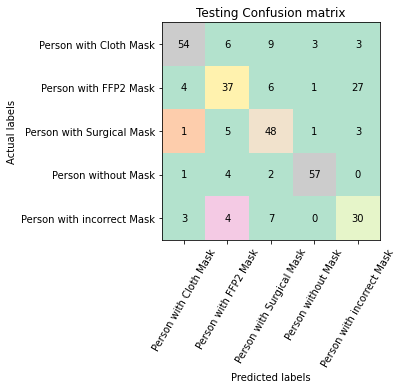

Running Fold Num:  2
** Epoch 0 ** - Epoch Time 62
Train Loss = 1.7138
** Epoch 1 ** - Epoch Time 60
Train Loss = 1.4879
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.36
** Epoch 3 ** - Epoch Time 60
Train Loss = 1.2452
** Epoch 4 ** - Epoch Time 60
Train Loss = 1.1379
** Epoch 5 ** - Epoch Time 60
Train Loss = 1.0407
** Epoch 6 ** - Epoch Time 60
Train Loss = 0.9164
** Epoch 7 ** - Epoch Time 60
Train Loss = 0.8594
** Epoch 8 ** - Epoch Time 60
Train Loss = 0.7478
** Epoch 9 ** - Epoch Time 63
Train Loss = 0.6838
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.6161
** Epoch 11 ** - Epoch Time 60
Train Loss = 0.566
Mean Final Accuracy:  77.25696666666666 

Average Final Accuracy:  77.25696666666666 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        70
           1       0.80      0.46      0.59        52
           2       0.62      0.82      0.70        68
           3       0.78      0.97      0.87   

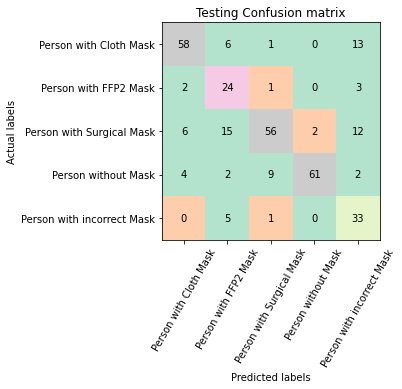

Running Fold Num:  3
** Epoch 0 ** - Epoch Time 61
Train Loss = 1.7699
** Epoch 1 ** - Epoch Time 61
Train Loss = 1.6043
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.5844
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.5315
** Epoch 4 ** - Epoch Time 61
Train Loss = 1.5212
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.3661
** Epoch 6 ** - Epoch Time 61
Train Loss = 1.2301
** Epoch 7 ** - Epoch Time 61
Train Loss = 1.252
** Epoch 8 ** - Epoch Time 61
Train Loss = 1.1217
** Epoch 9 ** - Epoch Time 61
Train Loss = 1.0418
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.987
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.9007
Mean Final Accuracy:  60.92016666666667 

Average Final Accuracy:  60.92016666666667 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.76      0.52      0.62        65
           1       0.25      0.17      0.20        59
           2       0.56      0.68      0.61        63
           3       0.85      0.83      0.84  

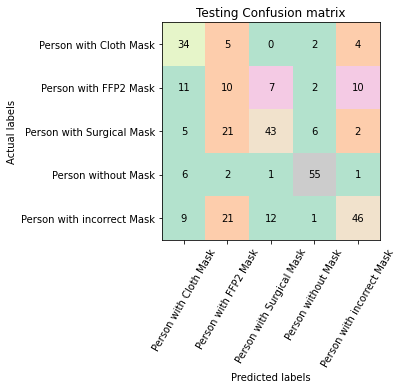

Running Fold Num:  4
** Epoch 0 ** - Epoch Time 59
Train Loss = 1.7164
** Epoch 1 ** - Epoch Time 60
Train Loss = 1.5627
** Epoch 2 ** - Epoch Time 60
Train Loss = 1.5212
** Epoch 3 ** - Epoch Time 59
Train Loss = 1.4012
** Epoch 4 ** - Epoch Time 61
Train Loss = 1.266
** Epoch 5 ** - Epoch Time 60
Train Loss = 1.0542
** Epoch 6 ** - Epoch Time 60
Train Loss = 0.9601
** Epoch 7 ** - Epoch Time 60
Train Loss = 0.8563
** Epoch 8 ** - Epoch Time 60
Train Loss = 0.7385
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.6459
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.5987
** Epoch 11 ** - Epoch Time 60
Train Loss = 0.5208
Mean Final Accuracy:  73.50693333333334 

Average Final Accuracy:  73.50693333333334 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        63
           1       0.45      0.50      0.47        52
           2       0.78      0.74      0.76        61
           3       0.93      0.81      0.86 

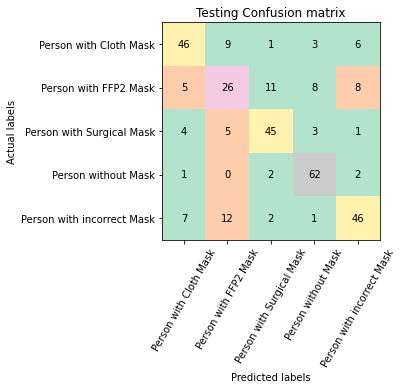

Running Fold Num:  5
** Epoch 0 ** - Epoch Time 60
Train Loss = 1.7447
** Epoch 1 ** - Epoch Time 60
Train Loss = 1.5306
** Epoch 2 ** - Epoch Time 60
Train Loss = 1.3843
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.2663
** Epoch 4 ** - Epoch Time 60
Train Loss = 1.1447
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.0505
** Epoch 6 ** - Epoch Time 60
Train Loss = 0.9474
** Epoch 7 ** - Epoch Time 60
Train Loss = 0.8127
** Epoch 8 ** - Epoch Time 60
Train Loss = 0.7957
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.707
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.6218
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.5586
Mean Final Accuracy:  70.24306666666666 

Average Final Accuracy:  70.24306666666666 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.66      0.83      0.74        69
           1       0.53      0.47      0.50        57
           2       0.83      0.70      0.76        71
           3       0.91      0.92      0.91 

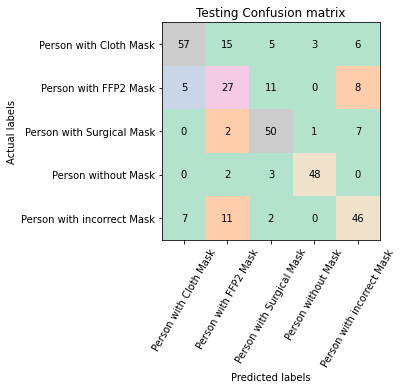

Running Fold Num:  6
** Epoch 0 ** - Epoch Time 64
Train Loss = 1.7112
** Epoch 1 ** - Epoch Time 61
Train Loss = 1.5587
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.4475
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.2848
** Epoch 4 ** - Epoch Time 62
Train Loss = 1.1995
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.1137
** Epoch 6 ** - Epoch Time 61
Train Loss = 1.0302
** Epoch 7 ** - Epoch Time 61
Train Loss = 0.9639
** Epoch 8 ** - Epoch Time 61
Train Loss = 0.814
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.7908
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.7064
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.5899
Mean Final Accuracy:  75.46786666666667 

Average Final Accuracy:  75.46786666666667 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        61
           1       0.58      0.41      0.48        61
           2       0.71      0.79      0.74        70
           3       0.88      0.95      0.92 

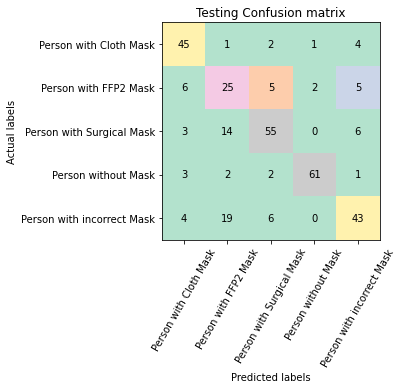

Running Fold Num:  7
** Epoch 0 ** - Epoch Time 62
Train Loss = 1.7452
** Epoch 1 ** - Epoch Time 61
Train Loss = 1.4995
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.3643
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.2033
** Epoch 4 ** - Epoch Time 62
Train Loss = 1.1413
** Epoch 5 ** - Epoch Time 62
Train Loss = 1.0204
** Epoch 6 ** - Epoch Time 61
Train Loss = 0.9244
** Epoch 7 ** - Epoch Time 62
Train Loss = 0.7589
** Epoch 8 ** - Epoch Time 65
Train Loss = 0.6609
** Epoch 9 ** - Epoch Time 62
Train Loss = 0.6071
** Epoch 10 ** - Epoch Time 62
Train Loss = 0.5268
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.5973
Mean Final Accuracy:  76.72583333333333 

Average Final Accuracy:  76.72583333333333 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.89      0.71      0.79        68
           1       0.63      0.43      0.51        63
           2       0.59      0.89      0.71        53
           3       0.95      0.95      0.95

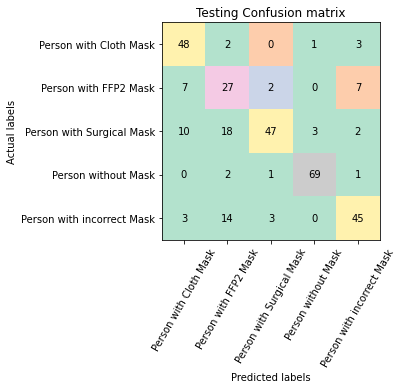

Running Fold Num:  8
** Epoch 0 ** - Epoch Time 61
Train Loss = 1.7252
** Epoch 1 ** - Epoch Time 60
Train Loss = 1.6008
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.5581
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.5016
** Epoch 4 ** - Epoch Time 61
Train Loss = 1.4077
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.2285
** Epoch 6 ** - Epoch Time 61
Train Loss = 1.1043
** Epoch 7 ** - Epoch Time 61
Train Loss = 0.9515
** Epoch 8 ** - Epoch Time 61
Train Loss = 0.8419
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.7369
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.6481
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.5968
Mean Final Accuracy:  69.1693 

Average Final Accuracy:  69.1693 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        61
           1       0.38      0.42      0.40        52
           2       0.77      0.70      0.73        70
           3       0.89      0.81      0.85        62
         

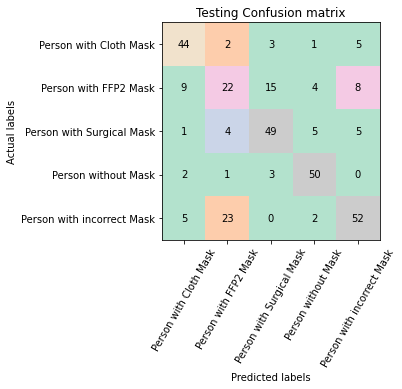

Running Fold Num:  9
** Epoch 0 ** - Epoch Time 61
Train Loss = 1.6586
** Epoch 1 ** - Epoch Time 61
Train Loss = 1.5232
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.3614
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.2659
** Epoch 4 ** - Epoch Time 61
Train Loss = 1.1409
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.0236
** Epoch 6 ** - Epoch Time 61
Train Loss = 0.9516
** Epoch 7 ** - Epoch Time 61
Train Loss = 0.8692
** Epoch 8 ** - Epoch Time 61
Train Loss = 0.7775
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.6638
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.5734
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.4963
Mean Final Accuracy:  77.50706666666666 

Average Final Accuracy:  77.50706666666666 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.78      0.66      0.71        58
           1       0.63      0.52      0.57        52
           2       0.70      0.77      0.73        62
           3       0.96      0.95      0.95

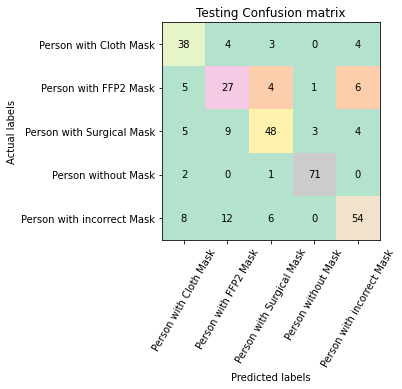

Running Fold Num:  10
** Epoch 0 ** - Epoch Time 61
Train Loss = 1.7547
** Epoch 1 ** - Epoch Time 62
Train Loss = 1.5472
** Epoch 2 ** - Epoch Time 61
Train Loss = 1.3998
** Epoch 3 ** - Epoch Time 61
Train Loss = 1.2764
** Epoch 4 ** - Epoch Time 61
Train Loss = 1.1017
** Epoch 5 ** - Epoch Time 61
Train Loss = 1.0111
** Epoch 6 ** - Epoch Time 61
Train Loss = 0.9054
** Epoch 7 ** - Epoch Time 62
Train Loss = 0.7834
** Epoch 8 ** - Epoch Time 61
Train Loss = 0.7372
** Epoch 9 ** - Epoch Time 61
Train Loss = 0.6439
** Epoch 10 ** - Epoch Time 61
Train Loss = 0.6219
** Epoch 11 ** - Epoch Time 61
Train Loss = 0.5301
Mean Final Accuracy:  74.2496 

Average Final Accuracy:  74.2496 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        72
           1       0.59      0.54      0.56        56
           2       0.68      0.82      0.74        55
           3       0.85      0.98      0.91        56
        

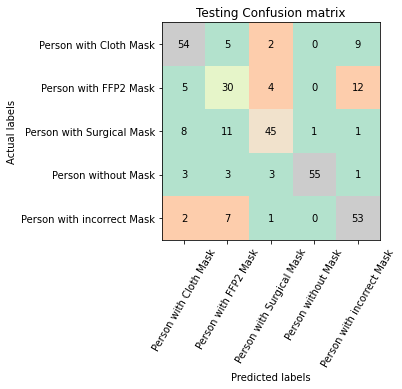

Average accuracy after running 10 folds is :  72.11752666666666


In [21]:
#Get device
avg_testing_accuracy = []

epochs = 12
kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_val = 1
max = 0
for training_idx, testing_idx in kfold.split(train_dataset):
        model = MaskDetect()
        model.apply(initialize_weights)
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        torch.cuda.empty_cache()

        model.to(device)


        #Training Details
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
        criterion = nn.CrossEntropyLoss()

        train_loss = []
        train_accuracy = []

        valid_loss = []
        valid_accuracy = []

        val_loss = []
        val_accuracy = []

        print("Running Fold Num: ", fold_val)
        training_dataset = Subset(train_dataset, training_idx)
        testing_dataset = Subset(train_dataset, testing_idx)
        training_loader = DataLoader(training_dataset, batch_size=128, num_workers=0,shuffle=True)
        testing_loader = DataLoader(testing_dataset, batch_size=128, num_workers=0, shuffle=True)
        return_model = train_model(model, optimizer, criterion, training_loader, epochs)
        testing_accuracy_of_each_fold = test_model(model, testing_loader)
        if testing_accuracy_of_each_fold > max:
            max = testing_accuracy_of_each_fold
            torch.save(model.state_dict(), "C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\Trained_Model.pt")
        avg_testing_accuracy.append(testing_accuracy_of_each_fold)
        fold_val+=1


print("Average accuracy after running 10 folds is : ", sum(avg_testing_accuracy)/len(avg_testing_accuracy))

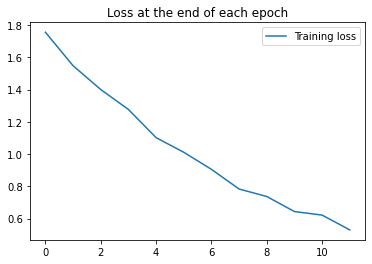

In [22]:
plt.plot(train_loss, label='Training loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()
# plt.plot(valid_loss, label='Validation loss')
# plt.title('Loss at the end of each epoch')
# plt.legend()

Testing for female data: 
Mean Final Accuracy:  22.1311 

Average Final Accuracy:  22.1311 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.73      0.41      0.52        27
           1       0.44      0.32      0.37        25
           2       0.12      0.12      0.12        26
           3       0.00      0.00      0.00        24
           4       0.11      0.20      0.15        20

    accuracy                           0.21       122
   macro avg       0.28      0.21      0.23       122
weighted avg       0.30      0.21      0.24       122
 

Confusion Matrix:


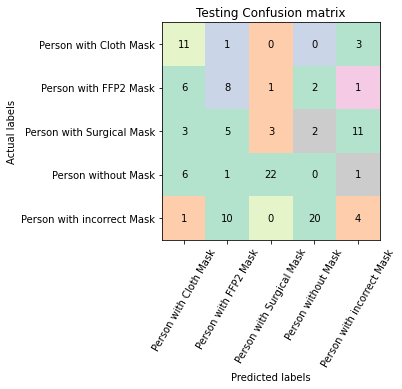

Testing for male data: 
Mean Final Accuracy:  22.9508 

Average Final Accuracy:  22.9508 

Testing Classification Report
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        27
           1       0.54      0.52      0.53        25
           2       0.11      0.12      0.12        25
           3       0.00      0.00      0.00        25
           4       0.06      0.10      0.07        20

    accuracy                           0.22       122
   macro avg       0.34      0.21      0.24       122
weighted avg       0.36      0.22      0.26       122
 

Confusion Matrix:


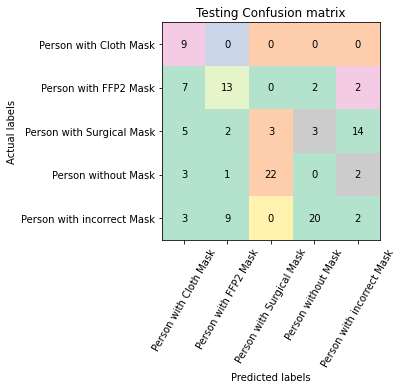

Testing for children data: 
Mean Final Accuracy:  23.5772 

Average Final Accuracy:  23.5772 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.63      0.48      0.55        25
           1       0.60      0.46      0.52        26
           2       0.15      0.12      0.13        26
           3       0.00      0.00      0.00        26
           4       0.06      0.10      0.07        20

    accuracy                           0.24       123
   macro avg       0.29      0.23      0.25       123
weighted avg       0.30      0.24      0.26       123
 

Confusion Matrix:


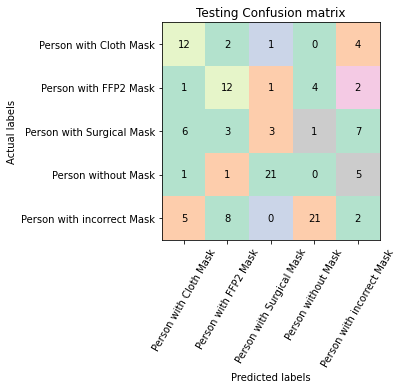

Testing for young data: 
Mean Final Accuracy:  29.5082 

Average Final Accuracy:  29.5082 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.82      0.56      0.67        25
           2       0.05      0.04      0.04        26
           3       0.00      0.00      0.00        26
           4       0.09      0.15      0.11        20

    accuracy                           0.32       122
   macro avg       0.37      0.32      0.34       122
weighted avg       0.37      0.32      0.34       122
 

Confusion Matrix:


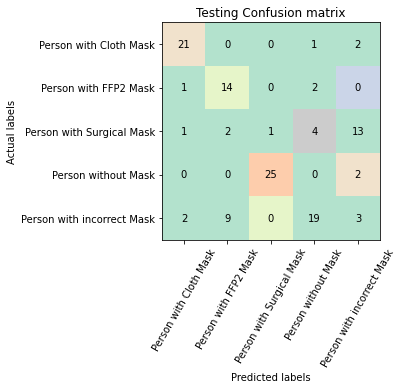

Testing for old data: 
Mean Final Accuracy:  33.0579 

Average Final Accuracy:  33.0579 

Testing Classification Report
              precision    recall  f1-score   support

           0       0.48      0.40      0.43        25
           1       0.71      0.65      0.68        23
           2       0.31      0.38      0.34        26
           3       0.05      0.04      0.04        27
           4       0.25      0.35      0.29        20

    accuracy                           0.36       121
   macro avg       0.36      0.36      0.36       121
weighted avg       0.35      0.36      0.35       121
 

Confusion Matrix:


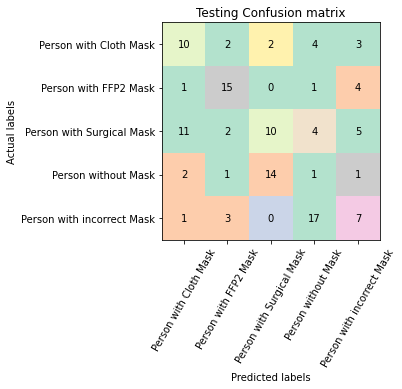

33.0579

In [33]:
model = MaskDetect()
model = model.to(device)
model.load_state_dict(torch.load('C:\\Users\\Yashvi\\Desktop\\AI\\AI PROJECT II\\AI Project Phase II\\Trained_Model.pt', map_location=device))

print("Testing for female data: ")
test_model(model, testing_female_loader)

#Testing for male data
print("Testing for male data: ")
test_model(model, testing_male_loader)

#Testing for children data
print("Testing for children data: ")
test_model(model, testing_children_loader)

#Testing for young data
print("Testing for young data: ")
test_model(model, testing_young_loader)

#Testing for old data
print("Testing for old data: ")
test_model(model, testing_old_loader)